In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

shipsnet_path = path + r"\\shipsnet.json"

Path to dataset files: C:\Users\wwden\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


In [31]:
import json

with open(shipsnet_path) as f:
    data = json.load(f)  # NOT json.dumps()

def print_structure(d, indent=0):
    prefix = '  ' * indent
    if isinstance(d, dict):
        for k, v in d.items():
            print(f"{prefix}{k}: {type(v).__name__}")
            print_structure(v, indent + 1)
    elif isinstance(d, list):
        print(f"{prefix}list[{len(d)}]: {type(d[0]).__name__}" if d else f"{prefix}list: empty")
        if d:
            print_structure(d[0], indent + 1)

print_structure(data)

data: list
  list[4000]: list
    list[19200]: int
labels: list
  list[4000]: int
locations: list
  list[4000]: list
    list[2]: float
scene_ids: list
  list[4000]: str


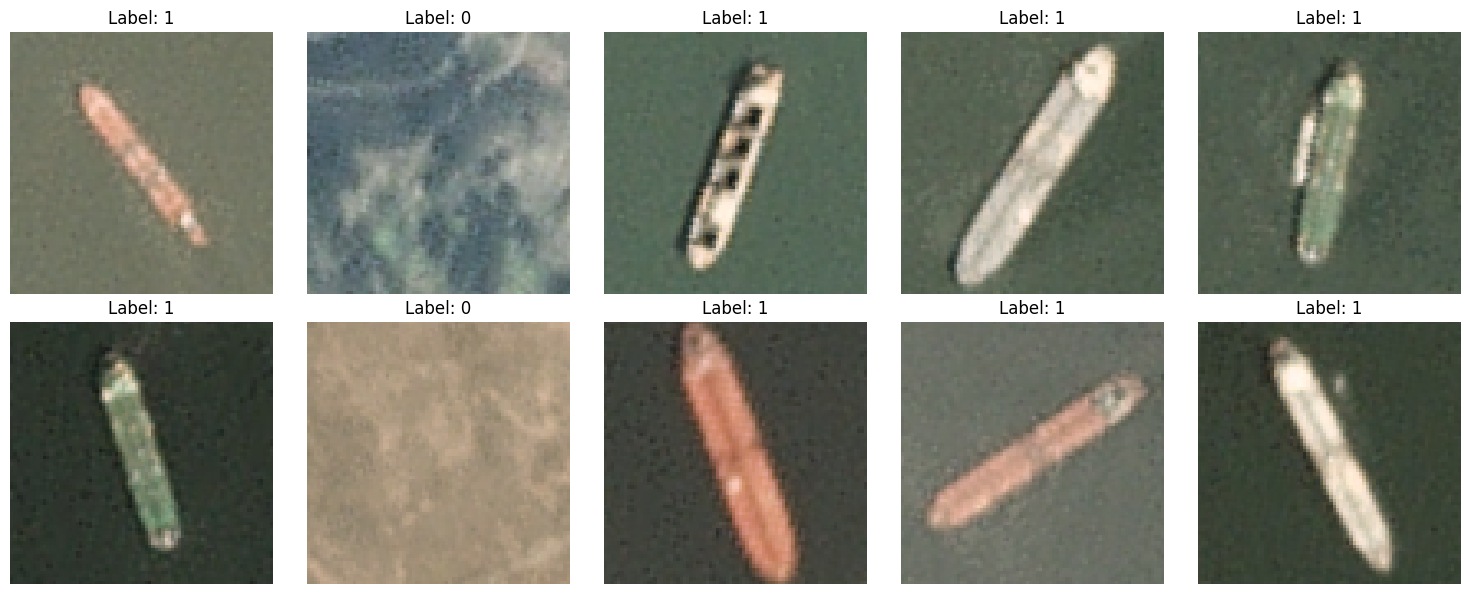

In [33]:
import numpy as np
import matplotlib.pyplot as plt

X_data = np.array(data["data"][:2000])
y_data = np.array(data["labels"][:2000])

X_data_transformed = X_data.reshape(-1, 3, 80, 80).transpose(0, 2, 3, 1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.randint(0,2000,size = 10)

for ax, idx in zip(axes.flat, indices):
    ax.imshow(X_data_transformed[idx].astype(np.uint8))
    ax.set_title(f"Label: {y_data[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [35]:
import os
import sys

# Save current working directory
cwd = os.getcwd()

# Change to parent directory
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
os.chdir(parent_dir)

# Temporarily add parent directory to sys.path
sys.path.insert(0, parent_dir)
import framework
sys.path.pop(0)

# Return to original directory
os.chdir(cwd)


In [65]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from CNN import CNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_tensor = torch.tensor(X_data_transformed, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Split indices
num_samples = X_tensor.size(0)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

indices = torch.randperm(num_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create splits
X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
X_test, y_test = X_tensor[test_idx], y_tensor[test_idx]

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNN(F.relu, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

best_loss = float('inf')

for epoch in range(1000):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if avg_loss > best_loss * 2:
        print("Stopping early due to loss increase")
        break

    best_loss = avg_loss

# Test evaluation
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = 100 * test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

cuda
Epoch 1 completed, Avg Loss: 0.7825, Accuracy: 75.94%
Epoch 2 completed, Avg Loss: 0.2187, Accuracy: 93.00%
Epoch 3 completed, Avg Loss: 0.1278, Accuracy: 95.62%
Epoch 4 completed, Avg Loss: 0.0948, Accuracy: 96.94%
Epoch 5 completed, Avg Loss: 0.0744, Accuracy: 97.94%
Epoch 6 completed, Avg Loss: 0.0729, Accuracy: 98.25%
Epoch 7 completed, Avg Loss: 0.0746, Accuracy: 97.44%
Epoch 8 completed, Avg Loss: 0.0543, Accuracy: 98.44%
Epoch 9 completed, Avg Loss: 0.0435, Accuracy: 98.69%
Epoch 10 completed, Avg Loss: 0.0484, Accuracy: 98.19%
Epoch 11 completed, Avg Loss: 0.0421, Accuracy: 98.44%
Epoch 12 completed, Avg Loss: 0.0358, Accuracy: 98.88%
Epoch 13 completed, Avg Loss: 0.0479, Accuracy: 98.19%
Epoch 14 completed, Avg Loss: 0.0291, Accuracy: 99.12%
Epoch 15 completed, Avg Loss: 0.0429, Accuracy: 98.69%
Epoch 16 completed, Avg Loss: 0.0420, Accuracy: 98.94%
Epoch 17 completed, Avg Loss: 0.0241, Accuracy: 99.31%
Epoch 18 completed, Avg Loss: 0.0362, Accuracy: 98.75%
Epoch 19 compl

In [ ]:
from framework.attack import Injector

inj = Injector(model, X_test, y_test)

In [64]:
train_loader.dataset.indices

[1371,
 760,
 490,
 904,
 930,
 204,
 312,
 1209,
 536,
 1040,
 680,
 32,
 1572,
 177,
 413,
 1082,
 98,
 342,
 1557,
 1847,
 1865,
 678,
 1379,
 154,
 1263,
 174,
 4,
 1652,
 767,
 1754,
 1780,
 571,
 1640,
 1903,
 1117,
 420,
 1833,
 912,
 962,
 970,
 803,
 1670,
 821,
 1357,
 172,
 1947,
 18,
 1262,
 766,
 68,
 407,
 448,
 1425,
 1573,
 1441,
 888,
 1628,
 506,
 470,
 527,
 158,
 1307,
 1149,
 1838,
 1434,
 1227,
 1367,
 1805,
 1685,
 42,
 1852,
 1558,
 1356,
 738,
 426,
 1529,
 1287,
 391,
 1234,
 292,
 675,
 196,
 1965,
 1396,
 1676,
 1879,
 572,
 1949,
 1706,
 298,
 830,
 1270,
 1242,
 1966,
 1445,
 1734,
 568,
 860,
 1854,
 1950,
 129,
 870,
 743,
 1200,
 1699,
 1636,
 523,
 1471,
 1449,
 380,
 91,
 770,
 1532,
 1669,
 818,
 1035,
 634,
 302,
 281,
 957,
 1795,
 441,
 1051,
 858,
 434,
 296,
 893,
 1760,
 1625,
 466,
 982,
 1688,
 402,
 1299,
 1019,
 236,
 1527,
 1119,
 1624,
 1665,
 784,
 1773,
 857,
 203,
 1375,
 1261,
 1767,
 113,
 15,
 1689,
 19,
 1621,
 1987,
 697,
 348,
 5